## ACP 166: Datos abiertos para ciudades resilientes
### Unidad 3: Riesgo climático
#### 12 de noviembre 2025

Objetivos

In [20]:
# pull GHSL pop data for downscaling
# pull Census data for vulnerability
# look *only* at the urban area of pergamino as our AOI, and at only the past 3 years max LST--should go much faster

In [ ]:
import geopandas as gpd

from pathlib import Path

import requests


from io import BytesIO
from owslib.wfs import WebFeatureService

import planetary_computer
import pystac_client
from dask.distributed import Client, LocalCluster
from odc.stac import configure_rio, stac_load
import matplotlib.pyplot as plt


from dask.diagnostics import ProgressBar
import rioxarray as rio


USE_CRS = "EPSG:5347"
CRS_WGS84 = "EPSG:4326"

RUTA_BASE = Path("/home/nissim/Documents/dev/datos-escala-humana/")
RUTA_DATOS = RUTA_BASE / "data"

In [22]:
def wfs_to_gdf(
    wfs_url: str, layer_name: str, srs: str = "EPSG:4326"
) -> gpd.GeoDataFrame:
    """
    Descarga una capa WFS y la devuelve como GeoDataFrame.

    Args:
        wfs_url (str): URL del servicio WFS.
        layer_name (str): Nombre de la capa (typename).
        srs (str): Código EPSG del sistema de referencia de coordenadas.

    Returns:
        gpd.GeoDataFrame: Capa descargada como GeoDataFrame.
    """
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")
    response = wfs.getfeature(typename=layer_name, srsname=srs)
    gdf = gpd.read_file(BytesIO(response.read()))
    return gdf


base_url = "https://wms.ign.gob.ar/geoserver/ign/ows"

if (RUTA_DATOS / "municipios.geojson").exists():
    munis = gpd.read_file(RUTA_DATOS / "municipios.geojson")
else:
    munis = wfs_to_gdf(wfs_url=base_url, layer_name="ign:municipio", srs="EPSG:4326")

pergamino = munis[munis["nam"] == "Pergamino"]
pergamino = pergamino.to_crs(USE_CRS)

bbox_pergamino_4326 = pergamino.to_crs(CRS_WGS84).total_bounds

In [23]:
# Base WMS URL (clean up the malformed URL)
wfs_url = "https://ide.pergamino.gob.ar:8443/geoserver/wfs"
layer_name = "publico:aglomerados_urbanos"

# Build GetFeature request
bbox_pergamino = pergamino.to_crs("EPSG:4326").total_bounds

params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typename": layer_name,
    "outputFormat": "application/json",
    "srsname": "EPSG:4326",
    "bbox": f"{bbox_pergamino[0]},{bbox_pergamino[1]},{bbox_pergamino[2]},{bbox_pergamino[3]},EPSG:4326",
}

response = requests.get(wfs_url, params=params)

if response.status_code == 200:
    aglomerados_urbanos = gpd.read_file(BytesIO(response.content))
    print(f"Loaded {len(aglomerados_urbanos)} features")
    print(f"CRS: {aglomerados_urbanos.crs}")

    # Clip to exact Pergamino boundary
    aglomerados_urbanos = aglomerados_urbanos.to_crs(pergamino.crs)

else:
    print(f"Error: {response.status_code}")
    print(response.text)

Loaded 166 features
CRS: EPSG:4326


In [24]:
aglomerados_urbanos.head()

,id,area,metodologia,clasificacion,distrito,fecha_actualizacion,fuente,definicion,descargo_responsabilidad,observaciones,seccion,geometry
0,160,1846.04,Los aglomerados son manchas territoriales cont...,urbana,Pergamino,07.2024,imágenes aéreas,Se entiende como un continuo urbano donde las ...,No se deberán tomar estos polígonos como datos...,None,4,"POLYGON ((5447824.192 6250167.097, 5447826.956..."
1,28,0.25,Los aglomerados son manchas territoriales cont...,periurbana,Pergamino,07.2024,imágenes aéreas,Se entiende como un continuo urbano donde las ...,No se deberán tomar estos polígonos como datos...,None,2,"POLYGON ((5446014.821 6253170.109, 5446036.84 ..."
2,30,2.24,Los aglomerados son manchas territoriales cont...,periurbana,Pergamino,07.2024,imágenes aéreas,Se entiende como un continuo urbano donde las ...,No se deberán tomar estos polígonos como datos...,None,1,"POLYGON ((5444072.648 6251627.258, 5444191.506..."
3,32,0.09,Los aglomerados son manchas territoriales cont...,periurbana,Pergamino,07.2024,imágenes aéreas,Se entiende como un continuo urbano donde las ...,No se deberán tomar estos polígonos como datos...,None,1,"POLYGON ((5444305.24 6251233.481, 5444294.2 62..."
4,41,0.18,Los aglomerados son manchas territoriales cont...,periurbana,Pergamino,07.2024,imágenes aéreas,Se entiende como un continuo urbano donde las ...,No se deberán tomar estos polígonos como datos...,None,2,"POLYGON ((5446217.105 6253403.15, 5446201.686 ..."


<Axes: >

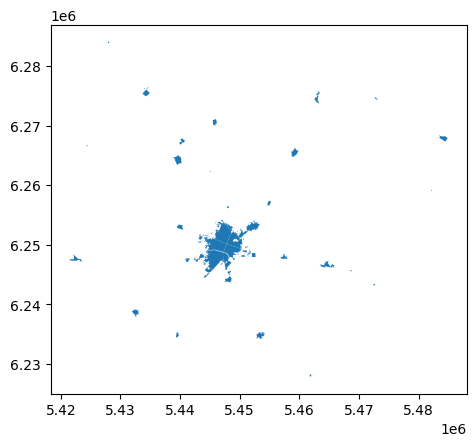

In [25]:
aglomerados_urbanos.plot()

In [26]:
aglomerados_urbanos[aglomerados_urbanos["clasificacion"] == "urbana"].shape

(6, 12)

<Axes: >

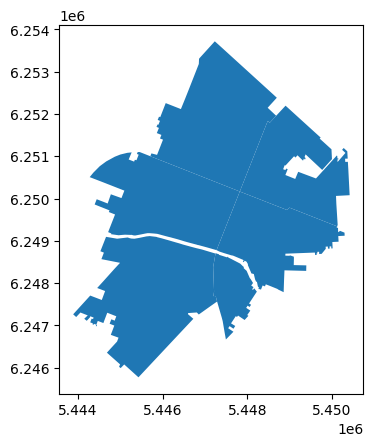

In [27]:
aglomerados_urbanos[aglomerados_urbanos["clasificacion"] == "urbana"].plot()

In [28]:
area_urbana = aglomerados_urbanos[aglomerados_urbanos["clasificacion"] == "urbana"]

In [29]:
bbox_area_urbana = area_urbana.to_crs("EPSG:4326").total_bounds

## LST via Landsat

In [43]:
# Connect to Planetary Computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

cluster = LocalCluster(
    processes=True,  # Critical: use processes, not threads
    n_workers=8,  # Use half your cores for workers
    threads_per_worker=2,  # 2 threads per worker = 16 total
    memory_limit="6GB",  # 8 workers × 6GB = 48GB, leaves headroom
)
client = Client(cluster)
print(f"Dask dashboard: {client.dashboard_link}")
configure_rio(cloud_defaults=True, client=client)

# query for 5 years
bbox = bbox_area_urbana
datetime = "2020-01-01/2025-01-01"
cloudy_less_than = 20

query = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloudy_less_than}},
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34505 instead
  warnings.warn(


Dask dashboard: http://127.0.0.1:34505/status
Found: 352 datasets


This currently takes about 5 minutes. I'll have to play around with it in Colab to see what the timing is like there--ideally, I'd like to get it down to around 2. Can probably just cut another year, although that carries certain issues of data quality. Maybe it's good for them to see a workflow take that long to run.

In [44]:
# Define output file path (same directory as notebook)
import os

notebook_dir = Path(os.path.dirname(os.path.abspath("pergamino.ipynb")))
lst_tif_path = notebook_dir / "LST_max_pergamino_area_urbana_TESTFORTALLER.tif"

# Check if file exists, otherwise compute
if lst_tif_path.exists():
    print(f"Loading existing LST data from {lst_tif_path}")
    LST_max_computed = rio.open_rasterio(lst_tif_path)
    # Squeeze out any extra dimensions if needed
    if len(LST_max_computed.dims) > 2:
        LST_max_computed = LST_max_computed.squeeze()
else:
    print("Computing LST from scratch...")
    # Load only thermal band and QA band
    crs = "epsg:3857"
    yy = stac_load(
        items,
        bands=("lwir11", "qa_pixel"),
        crs=crs,
        resolution=30,
        chunks={"time": 10},  # Process in chunks of 10 time steps
        groupby="landsat:scene_id",
        bbox=bbox,
    )

    # Create cloud mask function
    def create_cloud_mask(qa_band):
        """Mask clouds and cloud shadows"""
        # Bit 3: Cloud, Bit 4: Cloud Shadow
        cloud_mask = (qa_band & 0b11000) == 0
        return cloud_mask

    # Apply cloud mask
    yy_masked = yy.where(create_cloud_mask(yy.qa_pixel))

    # Convert thermal band to LST in Celsius
    LST_kelvin = yy_masked["lwir11"] * 0.00341802 + 149.0
    LST_celsius = LST_kelvin - 273.15

    # Calculate maximum LST per pixel over all time steps
    LST_max = LST_celsius.max(dim="time")

    # Before compute()
    print("Computing maximum LST...")
    print(f"Dashboard: {client.dashboard_link}")
    with ProgressBar():
        LST_max_computed = LST_max.compute()

    # Save to file
    print(f"Saving LST data to {lst_tif_path}")
    LST_max_computed.rio.to_raster(lst_tif_path)

Computing LST from scratch...
Computing maximum LST...
Dashboard: http://127.0.0.1:34505/status


/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


Saving LST data to /home/nissim/Documents/dev/datos-escala-humana/es/riesgo-climatico/LST_max_pergamino_area_urbana_TESTFORTALLER.tif


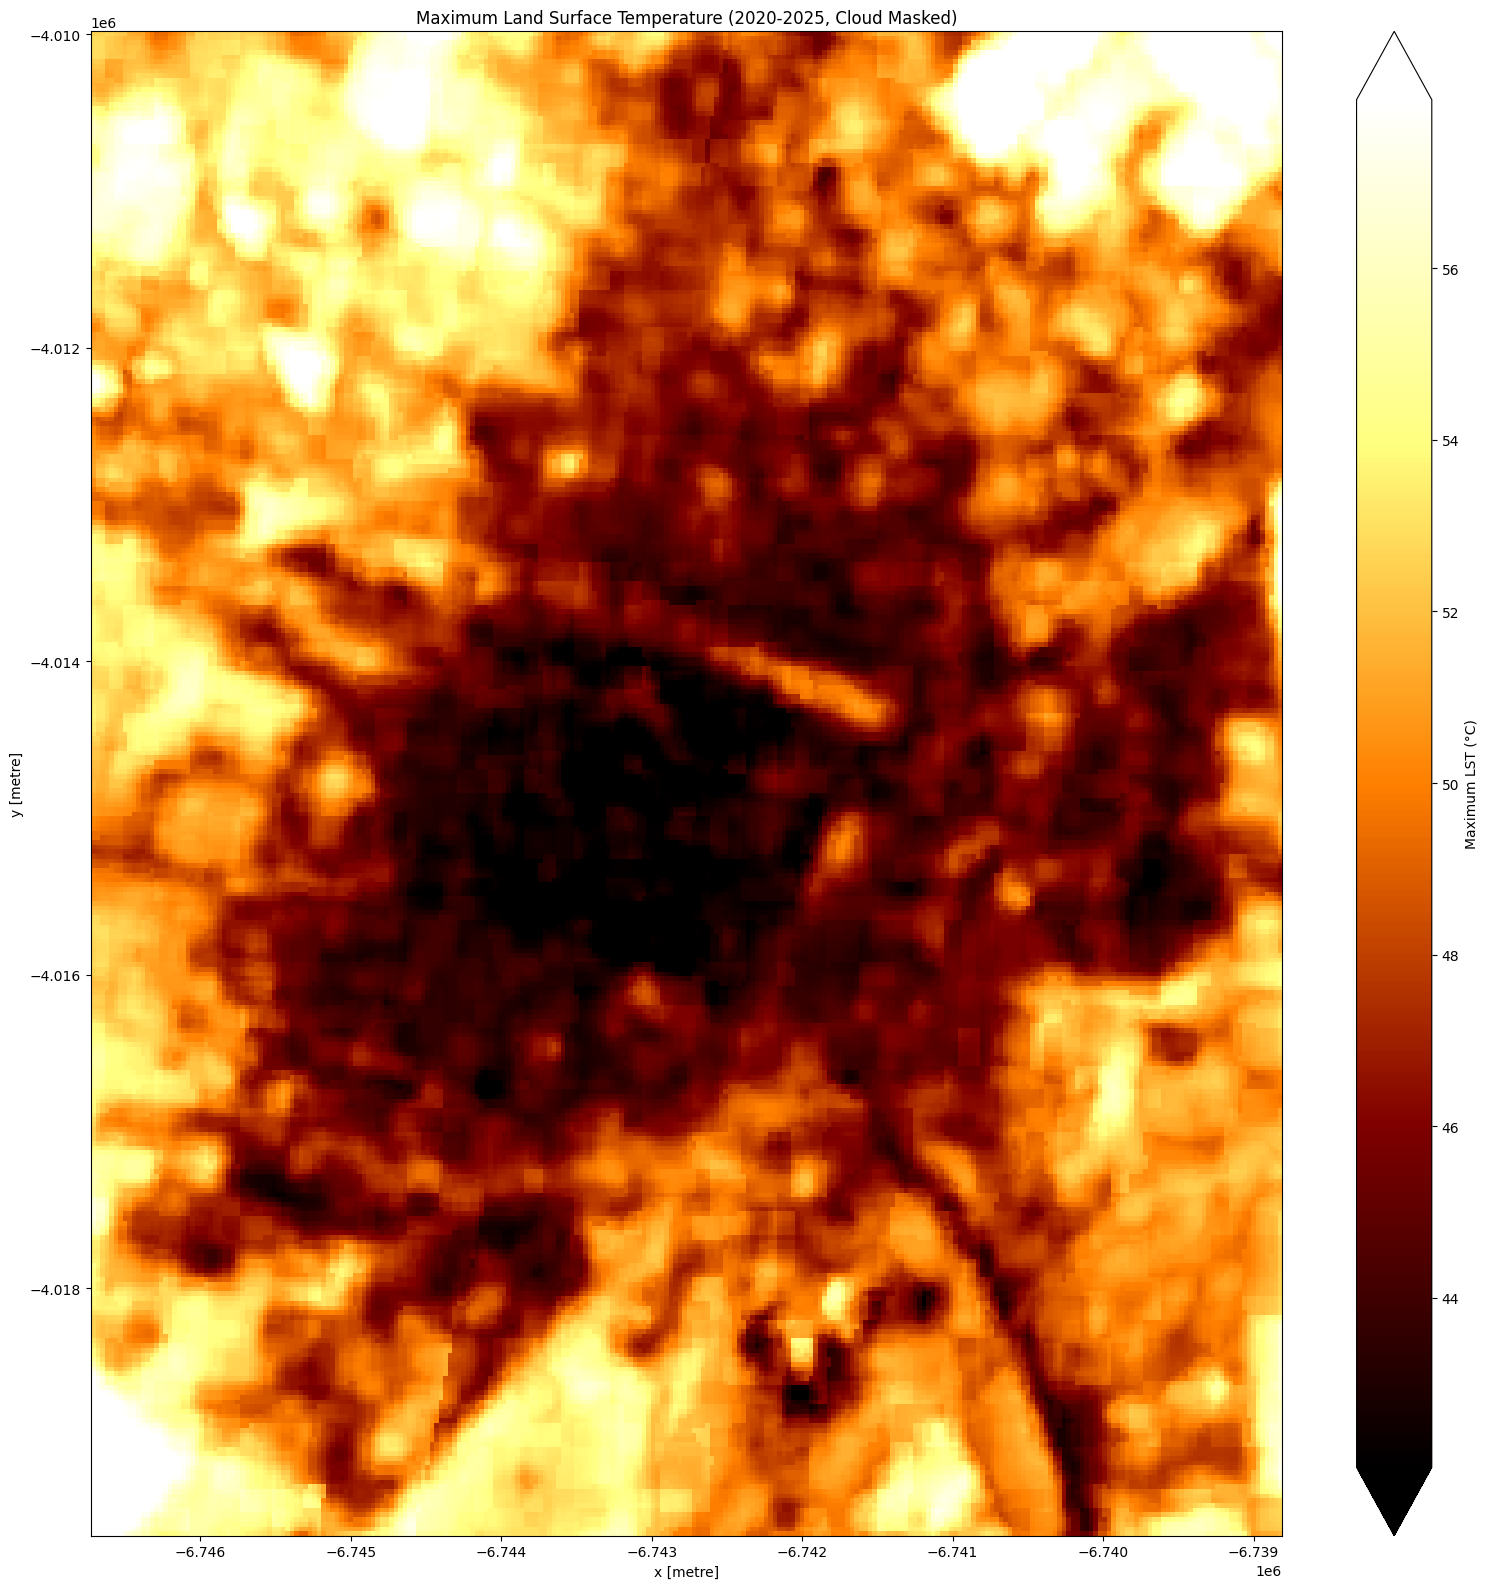

In [45]:
# Plot the result
fig, ax = plt.subplots(figsize=(16, 16))
LST_max_computed.plot.imshow(
    ax=ax,
    cmap="afmhot",
    cbar_kwargs={"label": "Maximum LST (°C)"},
    robust=True,  # Use 2nd and 98th percentiles for color scaling
)
ax.set_title("Maximum Land Surface Temperature (2020-2025, Cloud Masked)")
plt.tight_layout()
plt.show()

In [46]:
# Print some statistics
print("\nMaximum LST Statistics:")
print(f"  Overall max: {float(LST_max_computed.max().values):.2f}°C")
print(f"  Overall min: {float(LST_max_computed.min().values):.2f}°C")
print(f"  Mean of maximums: {float(LST_max_computed.mean().values):.2f}°C")
print(f"  Median of maximums: {float(LST_max_computed.median().values):.2f}°C")


Maximum LST Statistics:
  Overall max: 62.40°C
  Overall min: 38.88°C
  Mean of maximums: 48.95°C
  Median of maximums: 48.83°C


In [47]:
# print histogram
# print quantile breaks
# add interactive map over sateliite basemap
# what kind of observations can you make about the places with the highest LST?

## Exposure

In [ ]:
# pull in GHSL data
# downscale the census data with it

## Vulnerability

In [ ]:
# pull in the census vulnerability data
# calculate poverty

## Risk

In [49]:
# calculate the total population in the area,
# total population in poverty
# population in areas of high hazard
# pop in poverty in areas of high hazard

## Proposed Interventions

In [48]:
# look at the WRI article really quickly on things that could be tried
# what kind of interventions might you suggest here? why?

In [50]:
# if we have time, maybe pull in the tree cover dataset and compare hot areas to tree cover
# talk about this in terms of interventions